# Exercise: Houston Hobby (GHCN Daily PRCP) → Monthly + ENSO (ONI) Merge

**Goal:** Pull daily precipitation for **Houston Hobby** (`USW00012960`) from AWS, convert to **monthly totals (mm)**,
then merge with the **ONI** ENSO index.

You will implement the functions directly in this notebook (self-contained).


## 0) Setup
- Do **not** import from the package; implement inline.
- Use `fsspec` to read remote files.


In [10]:
from __future__ import annotations
from pathlib import Path
from typing import Optional, Sequence, Literal, Dict, Any
import io
import pandas as pd
import fsspec
import numpy as np

def _open_file(path: str | Path):
    with fsspec.open(str(path), mode='rb') as f:
        data = f.read()
    return io.BytesIO(data)

STOR = {"anon": True}


## 1) GHCN Daily for Houston Hobby Airport (USW00012960)
Implement a function to read the **single-station** CSV and convert PRCP from **tenths of mm** to **mm**.

**TODO:**
1. Read `https://noaa-ghcn-pds.s3.amazonaws.com/csv/USW00012960.csv`
2. Convert `DATE` to datetime
3. Convert `VALUE` for `ELEMENT == 'PRCP'` from tenths of mm → mm


In [11]:
GHCN_URL = 's3://noaa-ghcn-pds/csv/by_station/USW00012960.csv'

def load_station_daily(url: str) -> pd.DataFrame:
    # Reads CSV from AWS-hosted NOAA GHCN data
    df = pd.read_csv(
        url,
        storage_options=STOR,          # anonymous access to S3
        dtype={'ID': str, 'ELEMENT': str},
        parse_dates=['DATE']           # convert DATE to datetime
    )

    # Replaces missing data markers (-9999) with NaN
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)

    # Pivoting to wide format, one row per date, each variable as a column
    wide = (
        df.pivot_table(
            index=['ID', 'DATE'],
            columns='ELEMENT',
            values='DATA_VALUE',
            aggfunc='first'
        )
        .reset_index()
    )

    # Converting tenths-of-units to standard units
    for c in ('TMAX', 'TMIN', 'TAVG'):
        if c in wide:
            wide[c] = wide[c] / 10.0
    if 'PRCP' in wide:
        wide['PRCP'] = wide['PRCP'] / 10.0

    # Setting DATE as index for time series operations
    wide = wide.set_index('DATE')

    return wide

# Running the function for Houston Hobby Airport
daily = load_station_daily(GHCN_URL)
daily.head()


C:\Users\tnaut\AppData\Local\Temp\ipykernel_32512\3925041454.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


ELEMENT,ID,ACMH,ACSH,ADPT,ASLP,ASTP,AWBT,AWND,FMTM,PGTM,...,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WV03
DATE,,,,,,,,,,,,,,,,,,,,,
1969-06-01,USW00012960,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-06-02,USW00012960,70.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-03,USW00012960,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1100.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-04,USW00012960,90.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,906.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-05,USW00012960,50.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,1048.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Resample to monthly sums (mm)
**TODO:**
1. Filter PRCP rows only
2. Set DATE to index and resample to month-start (`'MS'`) **sum**
3. Return a single-column `Series` named `prcp_mm`


In [12]:
def ghcn_prcp_monthly_sum(df: pd.DataFrame) -> pd.Series:
    # Ensuring the index is datetime (DATE) for resampling
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'DATE' in df.columns:
            df = df.set_index('DATE')
        else:
            raise ValueError("Input must have a DatetimeIndex or a 'DATE' column.")

    # Filtering PRCP only
    pr = df['PRCP']

    # Resample to month-start sum (keep NaN for all-missing months)
    monthly = pr.resample('MS').sum(min_count=1)

    # Naming the output series
    monthly.name = 'prcp_mm'
    return monthly

# To build monthly Houston precip
hou_monthly = ghcn_prcp_monthly_sum(daily).to_frame()
hou_monthly.index.name = 'date'
hou_monthly


,prcp_mm
date,
1969-06-01,38.4
1969-07-01,98.8
1969-08-01,67.9
1969-09-01,154.6
1969-10-01,83.8
...,...
2024-10-01,8.2
2024-11-01,101.7
2024-12-01,92.7


## 3) Read ONI (ENSO) from NOAA PSL
ONI table: `https://psl.noaa.gov/data/correlation/oni.data`

**TODO:** Parse the fixed-width-ish text table into a monthly Series named `oni` with timestamps at month start.


In [13]:
ONI_URL = "https://psl.noaa.gov/data/correlation/oni.data"

def read_oni_psl(url: str = ONI_URL) -> pd.Series:
    # Reading text directly from NOAA PSL using fsspec
    with fsspec.open(url, "r") as f:
        text = f.read()

    # Splitting lines and removing blanks
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]

    data = []
    for ln in lines:
        parts = ln.split()
        # Skipping headers or malformed rows
        if not parts or not parts[0].isdigit():
            continue

        year = int(parts[0])
        vals = parts[1:13]  # 12 months expected
        if len(vals) < 12:
            continue

        # Building (timestamp, value) pairs for each month
        for m, v in enumerate(vals, start=1):
            try:
                val = float(v)
            except ValueError:
                continue
            data.append((pd.Timestamp(year=year, month=m, day=1), val))

    # Converting to pandas Series, indexed by month-start timestamps
    s = pd.Series({t: v for t, v in data}).sort_index()
    s.name = "oni"
    return s

# Running the parser
oni = read_oni_psl().to_frame()
oni.index.name = "date"
oni.head()


,oni
date,
1950-01-01,-1.53
1950-02-01,-1.34
1950-03-01,-1.16
1950-04-01,-1.18
1950-05-01,-1.07


## 4) Build monthly precip and merge with ONI
**TODO:**
- Merge on the monthly timestamp using `merge_frames(..., how='left')`


In [14]:
def merge_frames(left: pd.DataFrame, right: pd.DataFrame, on: str, how: str = "left") -> pd.DataFrame:
    """Thin wrapper around pandas.merge to match the required API."""
    return pd.merge(left, right, on=on, how=how)

# To ensure we have hou_monthly (from Cell 2) and oni (from Cell 3)
assert 'hou_monthly' in globals(), "Run Cell 2 to create 'hou_monthly'."
assert 'oni' in globals(), "Run Cell 3 to create 'oni'."

# Prepare monthly keys as Period[M] for a clean, unambiguous month join
left = hou_monthly.reset_index().rename(columns={'date': 'dt'})
left['month'] = pd.to_datetime(left['dt']).dt.to_period('M')
left = left[['month', 'prcp_mm']]

right = oni.reset_index().rename(columns={'date': 'dt'})
right['month'] = pd.to_datetime(right['dt']).dt.to_period('M')
right = right[['month', 'oni']]

# Merging on the monthly timestamp using the required helper
monthly_merged = (
    merge_frames(left, right, on='month', how='left')
    .sort_values('month')
    .reset_index(drop=True)
)

monthly_merged.head()


,month,prcp_mm,oni
0,1969-06,38.4,0.43
1,1969-07,98.8,0.36
2,1969-08,67.9,0.51
3,1969-09,154.6,0.79
4,1969-10,83.8,0.86


## 5) Visualization
**TODO:**
- Plot monthly precipitation and ONI using monthly values during December, January, and February only.
- Compute correlation coefficient [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html] between `prcp_mm` and `oni` using monthly values during December-February.

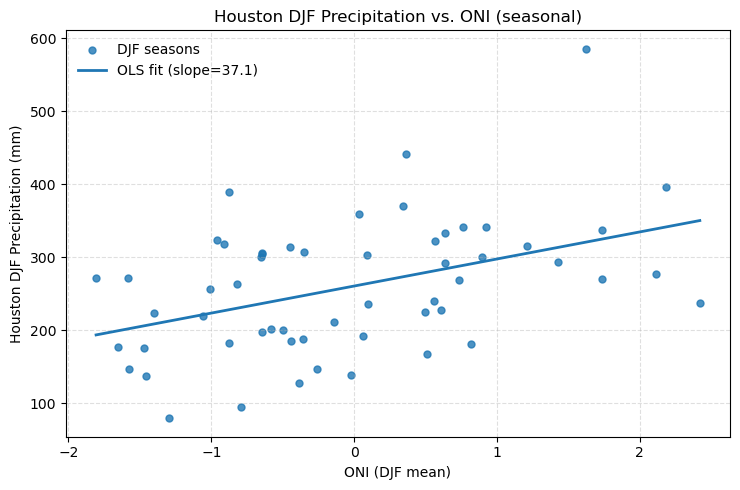

DJF seasonal Pearson r: 0.432 (n=56)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# I expect monthly_merged with columns: month (Period[M]), prcp_mm, oni
df = monthly_merged.copy()

# Keeping only DJF months
df["m"] = df["month"].dt.month
djf = df[df["m"].isin([12,1,2])].dropna(subset=["prcp_mm","oni"]).copy()

# Defining "season year" so Dec belongs to the following year's DJF (e.g., 1990-12 -> 1991 DJF)
djf["season_year"] = djf["month"].dt.year.where(djf["m"] != 12, djf["month"].dt.year + 1)

# Seasonal totals (precip) and seasonal mean (ONI) for DJF
seasonal = (djf.groupby("season_year")
              .agg(prcp_mm=("prcp_mm","sum"), oni=("oni","mean"))
              .dropna()
              .reset_index())

# Scatter and least-squares line
x = seasonal["oni"].values
y = seasonal["prcp_mm"].values

coef = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)
yy = coef[0]*xx + coef[1]

plt.figure(figsize=(7.5,5))
plt.scatter(x, y, s=25, alpha=0.8, label="DJF seasons")
plt.plot(xx, yy, linewidth=2, label=f"OLS fit (slope={coef[0]:.1f})")
plt.xlabel("ONI (DJF mean)")
plt.ylabel("Houston DJF Precipitation (mm)")
plt.title("Houston DJF Precipitation vs. ONI (seasonal)")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

r = np.corrcoef(x, y)[0,1]
print(f"DJF seasonal Pearson r: {r:.3f} (n={len(seasonal)})")
